##I. Descrição do problema##

Dataset  composto por medidas de PA de pacientes , sendo divididas em SBP e DBP.

Medidas coletadas a cada 15´ em 3 turnos e 30´ em 1 turno = 82 medidas em 24h


Há 9 tipos de Doenças Padrão conhecidas: White-Coat, Dipping, Non-Dipping, Masked, Ambulatory Hypotension, Isolated Systolic, Isolated Diastolic, Reverse Dipping, Morning Surge. E um padrão, que não é considerado doença, mas deve compor a classificacção que é Normotenso.

**Objetivo:** clusterizar os padrões de doenças


**DEFINIÇÕES**

IDADE >=60 then é idoso, else é jovem

**PERÍODOS**

* Matutino: 6h-8h59
* Diurno: 9h-20h59
* Vespertino: 21h-22h59
* Noturno: 23h-05h59



**Para SBP:**

LINHA_MAX = 140			LINHA_MIN = 100		

**Para DBP:**

LINHA_MAX = 90			LINHA_MIN = 60

**PADRÕES de DOENÇAS**

* WHITE COAT: 1a. média SBP >= todas outras médias
* MASKED:   if NOTURNO and any SBP>=140,  informar qtde de janelas >=140
* AMBULATORY HIPOTENSION: if any SBP <90 or any DBP <60
* ISOLATED SYSTOLIC:  if any SBP >140 and 60< DBP <90 ?????? 
* ISOLATED DIASTOLIC:  100< SBP <140 and any DBP >90
* DIPPING:  calcular SPB diurna; calcular SBP noturna; 
   Calcular dif=% da SBP noturna comparado com a diurna
      if 10< dif < 20 then DIPPING
      if dif > 10 then NON DIPPING
      if dif > 20 then EXTREME DIPPING
* REVERSE DIPPING: if SBP Noturna >= SBP Diurna
* MORNING SURGE:  if DIPPING, calcular SBP matinal
      if SBP matinal > 10% da SBP Noturna
* NORMOTENSA



##Abordagem do problema##

Tipo de aprendizagem:  Aprendizagem não supervisionada (Clausterização)

Dados: Dataset com 7.915 pacientes e 603.576 medidas de Pressão Arterial (PA) considerando a Sistólica (SBP) e Diastólica (DSP) coletadas por 24 horas, sendo a cada 15 minutos nos períodos Diurno, Matutino, Vespertino e a cada 30 minutos no período Noturno. Dessa forma, totalizamos 82 medidas diárias por paciente. Essa base de dados contém pacientes do gênero masculino e feminino com idade mínima de 10 anos e máxima de 100 anos. O método de coleta das medidas foi realizado com metodologia padrão acreditada pela American College of Cardiology/American Heart Association Task Force.

Modelo:

Objetivo: Utilizar método de análise automatizada para identificar e classificar cada paciente nos nove padrões de doenças Hipertensiva e um padrão normal descrita pela sociedade médica e, identificar padrões não conhecidos, caso existam.

Críterio:

Técnica de otimização: K-means

Importa as bibliotecas necessárias

In [1]:
''' # Cria o arquivo de configuracao

# Esse arquivo fica fora do GIT e guarda as diferencas de diretorios
# entre diferentes computadores. Todos os notebooks do projeto
# vao ler as configurações desse arquivo

a = open('config_diretorios.py', 'wt')
a.write("""\
from pathlib import Path

DRIVE = Path("C:\\\\")
DIR_PREFIXO = "users/marta/Documents"
""")
a.close()
'''

' # Cria o arquivo de configuracao\n\n# Esse arquivo fica fora do GIT e guarda as diferencas de diretorios\n# entre diferentes computadores. Todos os notebooks do projeto\n# vao ler as configurações desse arquivo\n\na = open(\'config_diretorios.py\', \'wt\')\na.write("""from pathlib import Path\n\nDRIVE = Path("C:\\\\")\nDIR_PREFIXO = "users/marta/Documents"\n""")\na.close()\n'

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import datetime
import math
import chart_studio.plotly as py
from pathlib import Path
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statistics
from plotly.subplots import make_subplots

# Configurações regionais para formatação de números, etc (ex. separador de milhar'.' e decimal ',')
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf-8')

# from prefixo_dados, import DRIVE, DIR_PREFIXO

config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())

DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"

# DIRETORIO_PRINCIPAL = Path(r"D:\Projeto_PA")

DIR_MODIFICADO = DIRETORIO_DATASET / "dataset_modificado"
DIR_QUANTITATIVOS = DIRETORIO_PRINCIPAL / "quantitativos"
DIR_ESTATISTICAS = DIRETORIO_PRINCIPAL / "estatisticas"
DIR_SAIDA = DIRETORIO_PRINCIPAL / "imputacao"
DIR_GRAFICOS = DIR_SAIDA

# define que pacientes com mais de 70% das medidas faltantes são descartados
LIMIAR_DE_DESCARTE = 0.3

Carrega a base de dados e exibe os 5 primeiros pacientes

In [3]:

filepath = DIR_MODIFICADO / r'pacientes_com_medidas_whitecoat.csv'

dados_brutos = pd.read_csv(filepath ,encoding='cp860',sep=';')
                # index_col=0 # Descomentar se aparecer a coluna "Unnamed"

if "Unnamed: 0" in dados_brutos:
    dados_brutos.drop("Unnamed: 0", 1, inplace=True)
dados_brutos.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,sist 9:30,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,whitecoat
0,4,1923-10-05,M,94.0,85.0,160,2018-09-10 12:25:23,105.0,108.0,116.0,...,NaN,NaN,NaN,NaN,67.0,61.0,69.0,62.0,51.0,"[('12:39', 140.0, 80.0), ('12:48', nan, nan), ..."
1,5,1948-10-07,M,70.0,80.0,165,2018-12-26 07:39:41,103.0,114.0,82.0,...,NaN,74.0,NaN,NaN,NaN,60.0,74.0,70.0,67.0,"[('08:04', 114.0, 60.0), ('08:15', 111.0, 74.0..."
2,6,1999-03-23,M,19.0,100.0,197,2018-12-26 08:06:19,147.0,148.0,156.0,...,NaN,93.0,NaN,NaN,NaN,86.0,87.0,82.0,82.0,"[('08:11', 133.0, 86.0), ('08:15', 137.0, 87.0..."
3,7,1978-01-26,F,40.0,65.0,"1,64",2018-12-26 08:19:06,140.0,139.0,142.0,...,NaN,62.0,NaN,104.0,NaN,NaN,89.0,90.0,72.0,"[('08:22', 153.0, 89.0), ('08:30', 153.0, 90.0..."
4,8,1990-03-07,M,28.0,120.0,172,2018-12-26 08:26:59,NaN,110.0,101.0,...,NaN,NaN,93.0,68.0,91.0,NaN,NaN,81.0,72.0,"[('08:31', 106.0, 81.0), ('08:48', 116.0, 72.0..."


Seleciona somente as medidas de pressão sistólica e diastólica e ignora os outros campos para compor as entradas do algoritmo de aprendizagem

In [4]:
# Identifica o tamanho do dataset input e os nomes das colunas
# print('Size of dataset: ' + str(dados_brutos.shape ))
# print(list(dados_brutos))  # print feature list
# apenas as medidas dos pacientes
data_input = dados_brutos.loc[:,'sist 9:00':'diast 8:45'].copy()

qtd_antes_descarte = len(dados_brutos)

# data_input.values
# print(data_input.shape)

# Total de 82 medidas para cada tipo de dado:
df_sist_bruto = data_input.loc[:, "sist 9:00": "sist 8:45"]
df_diast_bruto = data_input.loc[:, "diast 9:00": "diast 8:45"]

# Dataframe com TODOS os campos
# Metadados = campos de cadastro, peso, data do exame
df_metadados = dados_brutos.loc[:, "numero_identificacao": "data_exame"]


In [5]:
data_input

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,105.0,108.0,116.0,104.0,106.0,98.0,NaN,107.0,NaN,NaN,...,41.0,NaN,NaN,NaN,NaN,67.0,61.0,69.0,62.0,51.0
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,NaN,NaN,74.0,NaN,NaN,NaN,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,NaN,93.0,NaN,NaN,NaN,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,NaN,62.0,NaN,104.0,NaN,NaN,89.0,90.0,72.0
4,NaN,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,NaN,NaN,93.0,68.0,91.0,NaN,NaN,81.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21132,114.0,120.0,164.0,116.0,119.0,126.0,123.0,NaN,122.0,159.0,...,87.0,NaN,59.0,74.0,68.0,86.0,NaN,107.0,106.0,93.0
21133,107.0,110.0,103.0,NaN,NaN,NaN,114.0,144.0,128.0,104.0,...,49.0,NaN,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0
21134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.0,68.0,83.0,84.0,85.0,NaN,NaN,NaN,NaN,NaN
21135,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,104.0,96.0,...,NaN,NaN,64.0,76.0,NaN,69.0,75.0,74.0,69.0,67.0


## Distribuição quanto a gênero dos pacientes ANTES da imputação e do descarte

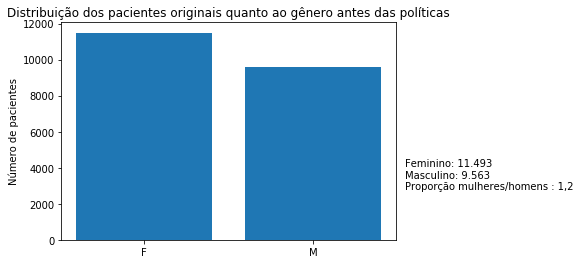

In [6]:
# Distribuição quanto ao gênero ANTES da imputação e do descarte
#


def plota_histograma_genero(dados, extra="antes das políticas"):
    
    gender = dados['genero'].value_counts()
    gender = gender[["F", "M"]]
    plt.bar(gender.index,gender)
    plt.gca().set(title=f'Distribuição dos pacientes originais quanto ao gênero {extra}', ylabel='Número de pacientes')
    
    legenda = f"Feminino: {gender['F']:n}\nMasculino: {gender['M']:n}"
    # Os operadores aumentados '+=', '-=', etc... fazem uma operação com, e guardam o resultado de volta, na variável da esquerda:
    # a = 10; a += 5 , resulta em a == 15
    legenda += "\n" + f"Proporção mulheres/homens : { gender['F'] / gender['M']:.02n}"
    plt.gcf().text(0.92, 0.3, legenda, fontsize=10)
    plt.savefig(DIR_GRAFICOS / f"grafico_distribuicao_genero_{extra.replace(' ', '_')}.svg", bbox_inches='tight')
          
plota_histograma_genero(dados_brutos)

## Distribuição quanto a idade dos pacientes ANTES da imputação e do descarte

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning:

invalid value encountered in greater_equal

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning:

invalid value encountered in less_equal



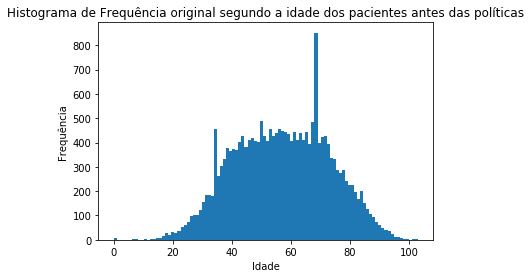

In [7]:
# Distribuição quanto à idade ANTES da imputação e do descarte
#

def plota_histograma_idade(dados, extra='antes das políticas'):
    data_nascimento = pd.to_datetime(dados_brutos.iloc[dados_brutos.index]['data_nascimento']).dt.date
    data_atual = datetime.date.today()
    idade = (data_atual - data_nascimento).astype('<m8[Y]')
    plt.hist(idade,bins=100)
    plt.gca().set(title=f'Histograma de Frequência original segundo a idade dos pacientes {extra}', ylabel='Frequência', xlabel='Idade')
    plt.savefig(DIR_GRAFICOS / f"grafico_distribuicao_idade_{extra.replace(' ', '_')}.svg", bbox_inches='tight')
                
plota_histograma_idade(dados_brutos)


In [8]:

statistics.median([130, 130, 140, 140])

data_input.columns

Index(['sist 9:00', 'sist 9:15', 'sist 9:30', 'sist 9:45', 'sist 10:00',
       'sist 10:15', 'sist 10:30', 'sist 10:45', 'sist 11:00', 'sist 11:15',
       ...
       'diast 6:30', 'diast 6:45', 'diast 7:00', 'diast 7:15', 'diast 7:30',
       'diast 7:45', 'diast 8:00', 'diast 8:15', 'diast 8:30', 'diast 8:45'],
      dtype='object', length=164)

## Realiza o preenchimento dos dados faltantes utilizando a média dos valores imediatamente anterior e posterior

In [9]:
# 
#  IMPUTAÇÃO
#
# Encontra as posições de medidas nos quais há o valor faltante e imputa dados artificiais com o critério de 
# média entre a medida anterior e a medida posterior
#
# MELHORIA FUTURA: calcular também séries inputando qualquer número de medidas faltantes, preenchendo com uma "reta"
# entre as medidas existentes (necessário também para área sob a curva)

def preenche_dados(medidas_de_pressao):
    """
        Recebe todas as colunas referentes a um tipo de medida - ex. df_sist e df_diast
        
        devolve data_frame com dados faltantes preenchidos de acordo com a regra:
           - se houver só um NaN entre duas medias boas é usada a mediana (= média, p/ 2 valores)
           entre essas medidas
           - no caso de mais valores NaN consecutivos, eles não são tocados.
        
        A função é chamada com os dados de medidas sistolicas,  e depois, com as diastolicas
        
        No notebook de 'padroes_de_doenca' há uma versão extendida dessa
        funçao que faz a inputação em multiplas colunas faltantes, com interpolação linear.
    """
    from statistics import median
    novas_linhas = []
    for _, linha in medidas_de_pressao.iterrows():
        nans = list(linha.isna())
        linha = list(linha)
        for i, isnan in enumerate(nans):
            if i == 0 or i == len(linha) - 1:
                continue
            if isnan and not nans[i - 1] and not nans[i + 1]:
                linha[i] = round(median((linha[i - 1], linha[i + 1])))
        novas_linhas.append(linha)
    return pd.DataFrame(columns=medidas_de_pressao.columns, data=novas_linhas)
#
print(df_sist_bruto.iloc[699:700, :].values)
print(preenche_dados(df_sist_bruto.iloc[699:700, : ]).values)

df_sist_preenchido = preenche_dados(df_sist_bruto)
df_diast_preenchido = preenche_dados(df_diast_bruto)
#  concatena Sist e Diast já preenchidas 
todas_as_medidas_preenchidas = pd.concat([df_sist_preenchido, df_diast_preenchido], axis=1)


[[151. 149. 161. 164. 152. 156. 141. 147. 126. 137. 126. 132. 187. 157.
   nan  nan  97.  nan 155. 141. 134. 138. 189.  nan  nan  nan  nan 139.
   nan  nan  nan 155. 129.  nan  nan 143.  nan 148.  96.  nan  nan  94.
   93. 120. 117. 116. 116. 115. 103. 102. 100. 118. 109. 112. 117. 119.
  123. 133. 134. 113. 117. 124. 117.  nan  nan  nan 142. 134. 140. 148.
  144.  nan 115.  nan 143. 126. 141. 145. 116. 125. 146. 157.]]
[[151. 149. 161. 164. 152. 156. 141. 147. 126. 137. 126. 132. 187. 157.
   nan  nan  97. 126. 155. 141. 134. 138. 189.  nan  nan  nan  nan 139.
   nan  nan  nan 155. 129.  nan  nan 143. 146. 148.  96.  nan  nan  94.
   93. 120. 117. 116. 116. 115. 103. 102. 100. 118. 109. 112. 117. 119.
  123. 133. 134. 113. 117. 124. 117.  nan  nan  nan 142. 134. 140. 148.
  144. 130. 115. 129. 143. 126. 141. 145. 116. 125. 146. 157.]]


## Identifica as células onde os valores estão nulos, ou seja, tentativas de medições em que ocorreram erros - antes e depois de preencher NaNs isolados (imputação)

# Verifica quais células apresentam NaN
# 1 para null e 0 para non null

In [10]:
#  Verifica quais células apresentam NaN
#  1 para null e 0 para non null

valores_nulos_bruto = pd.concat([df_sist_bruto.isnull(), df_diast_bruto.isnull()], axis=1)
#print(valores_nulos_bruto.iloc[39, :].values)

valores_nulos = pd.concat([df_sist_preenchido.isnull(), df_diast_preenchido.isnull()], axis=1)
print(valores_nulos.iloc[39, :].values)


faltantes_bruto = valores_nulos_bruto.sum(axis=1)
faltantes_preenchido = valores_nulos.sum(axis=1)
percentual_reducao = (100 * (1 - faltantes_preenchido / faltantes_bruto)).round(2)

qtd_sem_medidas=pd.concat([
        dados_brutos['numero_identificacao'],
        valores_nulos_bruto.sum(axis=1),
        valores_nulos.sum(axis=1),
        percentual_reducao
    ], 
    axis=1
)
qtd_sem_medidas.columns = ['Num ID', 'Qdt nulas', 'Qtd nulas pós-imputação', 'Eficácia imputação (%)']

# gera arquivo com quantidade de NaNs por paciente

qtd_sem_medidas.to_excel(DIR_SAIDA / 'Quantidade_de_Medidas_Faltantes_por_Paciente.xlsx',
                        index=False)

qtd_sem_medidas.head()

[False False False False False False False False False False False False
 False False False False False False  True  True False False False False
 False False False False False  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


,Num ID,Qdt nulas,Qtd nulas pós-imputação,Eficácia imputação (%)
0,4,50,32,36.00
1,5,12,12,0.00
2,6,10,6,40.00
3,7,10,4,60.00
4,8,52,42,19.23


In [11]:
def funcao(a, b):
    a[0] = 50
    print("dentro da funcao:", a, b)   
d = [20,]
e = [30, ]
print("antes:", d, e)
funcao(d, e)
print("depois da funcao:", d, e)

x = pd.DataFrame([[10, 20, 30], [40, 50, 60], [70, 80, 90]], columns=["primeira", "segunda", "terceira"])
# print(x)
y = x.iloc[0, 0] = 100
# print(x, y, sep="\n\n")

def f2():
    return 5, 6

g, h = f2()
print("g:", g, "h:", h)

antes: [20] [30]
dentro da funcao: [50] [30]
depois da funcao: [50] [30]
g: 5 h: 6


In [12]:
#
#  Calcula o percentual de medidas ausentes


def calcula_percentual(df_medidas, percentual):
    # Verifica quais células apresentam NaN
    # todas_as_medidas = dados_brutos.concat([df_sist, df_diast], axis=1)
    valores_invalidos = df_medidas.isnull()
    # calcula a quantidade de NaNs por paciente
    indices_a_descartar = valores_invalidos.sum(axis=1) > percentual * df_medidas.shape[1]
    indices_a_descartar.name = "Descartado"
    return indices_a_descartar

#
# Grava csv com pacientes imputados E ainda não descartados

def grava_csv_qtd_so_imputados(indices_a_descartar): 
    df_soma_nulos = todas_as_medidas_preenchidas.isnull().sum(axis=1)
    df_soma_nulos.name = "Qtd NaNs"
    df_com_informacoes_de_validade = pd.concat([df_metadados, todas_as_medidas_preenchidas, 
                                                df_soma_nulos, indices_a_descartar], axis=1) 
    df = df_com_informacoes_de_validade
    
    # df_com_informacoes_de_validade.columns = list(pacientes_apos_regras.columns[:-2]) + ["Qtd NaNs", "Descartado"]
    df.to_csv(DIR_MODIFICADO / "pacientes_inputados_e_nao_descartados.csv", 
                                          sep=";", encoding="latin1")
    
   

# o operador "~" é de "complemento", e pode ser usado com a coluna de valores booleanos
# para selecionar só as linhas que estão marcadas como "False"
#
#  Roda função para Descartar pacientes e gerar 2 dataframes, sendo um completo e outro sem a coluna de Whitecoat

def realiza_descarte_com_Whitecoat(indices_a_descartar, df_metadados, df_sist_para_funcao, df_diast_para_funcao, df_whitecoat):
    """Processa os dados e descarta os pacientes indicados - 
    retorna 6 dataframes em sequencia, com os pacientes respectivamente removidos
    """

    df_sist_descartado = df_sist_para_funcao[~indices_a_descartar]
    df_diast_descartado = df_diast_para_funcao [~indices_a_descartar]
    df_metadados = df_metadados.copy()[~indices_a_descartar]
    df_whitecoat = df_whitecoat.copy()[~indices_a_descartar]
    dados_apos_descarte = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado], axis=1)
    dados_apos_descarte_com_Whitecoat = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado, df_whitecoat], axis=1)
    
    return (
        dados_apos_descarte,
        dados_apos_descarte_com_Whitecoat,
        df_metadados,
        df_sist_descartado,
        df_diast_descartado,
        df_whitecoat
    )

## Funcao anterior, que não levava em conta a coluna de whitecoat
#
#def realiza_descarte(indices_a_descartar, df_metadados, df_sist_para_funcao, df_diast_para_funcao):
#    df_sist_descartado = df_sist_para_funcao [~indices_a_descartar]
#    df_diast_descartado = df_diast_para_funcao [~indices_a_descartar]
#    df_metadados = df_metadados.copy()[~indices_a_descartar]
#    dados_apos_descarte = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado], axis=1)
#    return dados_apos_descarte, df_metadados, df_sist_descartado, df_diast_descartado

In [13]:

def grava_arquivos_finais(limiar_de_descarte, sufixo=""):
    # Chama função CALCULA_PERCENTUAL aplicando a regra de descarte > 70% de medidas faltantes (variável LIMIAR_DE_DESCARTE)
    indices_a_descartar = calcula_percentual(todas_as_medidas_preenchidas, limiar_de_descarte)

    grava_csv_qtd_so_imputados (indices_a_descartar)

    total_descartados = indices_a_descartar.sum()

    print(f"Total de pacientes a descartar com limiar {limiar_de_descarte}: {total_descartados}. Total de aceitos: {len(indices_a_descartar) - total_descartados}")

    df_info = pd.DataFrame([[qtd_antes_descarte, qtd_antes_descarte -  total_descartados, total_descartados],  ],
                           columns=["Total de pacientes", "total após descarte", "Quantidade de descartes"])
    df_info.to_csv(DIR_MODIFICADO / "totais_bruto_e_descartados.csv", sep=";", encoding="latin1", index=False)

    ####################################################################################################
    # Gera Dataframe com os pacientes imputados E descartados com todos os campos de medidas e meta-dados
    ####################################################################################################
    pacientes_aceitos, pacientes_apos_regras, df_metadados_apos_regras, df_sist_apos_regras, df_diast_apos_regras, df_whitecoat_apos_regras = \
        realiza_descarte_com_Whitecoat(
            indices_a_descartar=indices_a_descartar, 
            df_metadados=df_metadados,
            df_sist_para_funcao=df_sist_preenchido,
            df_diast_para_funcao=df_diast_preenchido,
            df_whitecoat=dados_brutos[["whitecoat"]]
    )

    # pacientes_aceitos <- dataframe completo sem o whitecoat
    # pacientes_apos_regras <- dataframe completo, com a coluna de dados brutos para calculo do whitecoat


    todas_as_medidas_apos_regras = pd.concat([df_sist_apos_regras, df_diast_apos_regras], axis=1)

    # Dataframe com todos os dados dos pacientes aceitos após imputação e regra de descarte E Whitecoat
    # pacientes_apos_regras

    # Dataframe SEM Whitecoat com todos os dados dos pacientes aceitos após imputação e regra de descarte
    # pacientes_aceitos

    # Grava CSV mantendo dataframe com todos os campos de medidas e meta-dados:
    #  COM Whitecoat
    pacientes_apos_regras.to_csv(DIR_MODIFICADO / f"pacientes_apos_regras_com_whitecoat{'_' + sufixo if sufixo else ''}.csv", sep=";", encoding="Latin1")

    # Grava CSV final mantendo dataframe com os campos de medidas e meta-dados, SEM WHITECOAT:
    #  SEM Whitecoat
    pacientes_aceitos.to_csv(DIR_MODIFICADO / f"pacientes_aceitos_SEM_whitecoat{'_' + sufixo if sufixo else ''}.csv", sep=";", encoding="Latin1")

    #print(indices_a_descartar, todas_as_medidas.loc[~ indices_a_descartar] ,sep="\n\n")

    # Grava arquivo com quantitativo de pacientes descartados
    #
    qtd_pacientes_a_descartar = indices_a_descartar.sum()
    total_pacientes = data_input.shape[0]

    sumario_de_descarte = pd.DataFrame([[
            qtd_pacientes_a_descartar, 
            total_pacientes, 
            f"{100 * qtd_pacientes_a_descartar / total_pacientes :.02f}%"]     
        ],
        columns=["Qdt Pacientes Descartados", "Qtd Pacientes Total", "Percentual de Descarte"]
    )

    sumario_de_descarte.to_csv(DIR_QUANTITATIVOS / f"Sumario_descartados{'_' + sufixo if sufixo else ''}.csv",
                            sep=';', index=False ,encoding='Latin1')   
    return pacientes_aceitos, pacientes_apos_regras

pacientes_aceitos, pacientes_apos_regras = grava_arquivos_finais(LIMIAR_DE_DESCARTE)
                             
grava_arquivos_finais(0, "_com_todas_as_medidas")
# Os dados de pacientes aceitos com todas as medidas não são guardados em variáveis: são descartados;
                             

Total de pacientes a descartar com limiar 0.3: 1576. Total de aceitos: 19561
Total de pacientes a descartar com limiar 0: 19952. Total de aceitos: 1185


(       numero_identificacao data_nascimento genero  idade   peso altura  \
 35                       39      1983-07-31      M   35.0  110.0   1,83   
 40                       44      1952-10-31      M   66.0   83.0   1,73   
 53                       57      1949-12-09      F   69.0   61.0    159   
 59                       63      1966-10-21      M   52.0   73.0    166   
 68                       72      1943-03-07      F   75.0   62.0    162   
 ...                     ...             ...    ...    ...    ...    ...   
 21061                 21708      1962-02-16      F   58.0   70.0    162   
 21099                 21749      1964-10-23      F   55.0   83.0    161   
 21101                 21751      1982-01-15      M   38.0   90.0    171   
 21117                 21768      1964-09-26      F   55.0   71.0    157   
 21120                 21771      1972-12-11      F   47.0   63.0   1,58   
 
                 data_exame  sist 9:00  sist 9:15  sist 9:30  ...  diast 6:30  \
 35  

## Distribuição quanto a gênero dos pacientes DEPOIS da imputação e do descarte

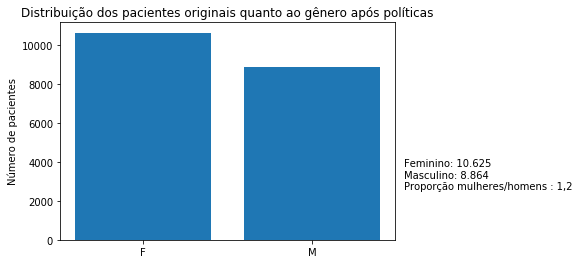

In [14]:
# Foram descartados 110 Mulheres e 84 Homens = 194   Faltam 3 ?????????????????????????????????????????????????

plota_histograma_genero(pacientes_apos_regras, extra='após políticas')



In [15]:
pacientes_aceitos.loc[1000]

numero_identificacao          1004
data_nascimento         1954-07-12
genero                           F
idade                           64
peso                            63
                           ...    
diast 7:45                      86
diast 8:00                      90
diast 8:15                      92
diast 8:30                      89
diast 8:45                      78
Name: 1000, Length: 171, dtype: object

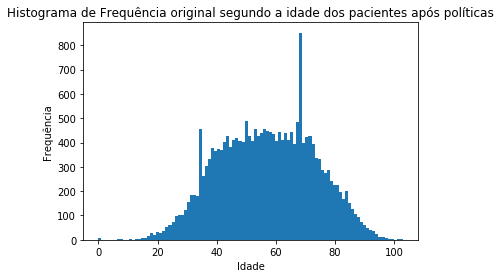

In [16]:
# Distribuição quanto à idade APÓS imputação e descarte


plota_histograma_idade(pacientes_apos_regras, extra='após políticas')


In [17]:
# Organizar 4 dataset com medidas de cada período 
# Matutino: 6h-8h59
# Diurno: 9h-20h59
# Vespertino: 21h-22h59
# Noturno: 23h-05h5


matutino=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 6:00':'sist 8:45'],dados_brutos.loc[:,'diast 6:00':'diast 8:45']),axis=1)
#matutino.head(10)
diurno=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 9:00':'sist 20:45'],dados_brutos.loc[:,'diast 9:00':'diast 20:45']),axis=1)
vespertino=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 21:00':'sist 22:45'],dados_brutos.loc[:,'diast 21:00':'diast 22:45']),axis=1)
noturno=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 23:00':'sist 5:30'],dados_brutos.loc[:,'diast 23:00':'diast 5:30']),axis=1)

In [18]:
# exemplo de uso e retorno da função "calcula_percentual"
indices_teste = calcula_percentual(noturno, .7)
sum(indices_teste)

# Exemplo de como funciona o dicionário retornado por "globals()"
# list(globals().keys())
# globals()["matutino"]

371

In [19]:
# Chama a função calcula_percentual para cada período. 
# Informar qual período se quer e, caso queira outro percentual diferente de 70

def gera_arquivos_de_invalidos_por_periodo(periodo, percentual):
    
    # Recupera o _valor_ da variável globa a partir do nome da variável como string:
    # (a chamada 'globals()' retorna todas as variáveis globais como um dicionário)
    dados_periodo = globals()[periodo]
    
    indices_a_descartar=calcula_percentual(dados_periodo, percentual)

    valido = dados_periodo[~indices_a_descartar]  # Pacientes válidos
    nao_valido = dados_periodo[indices_a_descartar] # Pacientes com mais de 70%  de dados faltantes no periodo noturno
    qtd_criterio = pd.Series(
        [sum(~indices_a_descartar), sum(indices_a_descartar), len(dados_periodo)],
        index = ["Atendido", "Não atendido", "Total"]
    )

    #periodo_matutino.head(10)
    valido.to_csv(path_or_buf= DIR_QUANTITATIVOS / f'Pacientes_com_Medidas_validas_periodo_{periodo}.csv',sep=';',index=False,encoding='latin1')
    nao_valido.to_csv(path_or_buf= DIR_QUANTITATIVOS / f'Pacientes_Nao_validos_periodo_{periodo}.csv',sep=';',index=False,encoding='latin1')
    # Usa 'index=True' pq nesse caso a série foi criada com os títulos de cada valor, que queremos ver no arquivo final:
    qtd_criterio.to_csv(path_or_buf= DIR_QUANTITATIVOS / f'Qtd_Criterio_atendido_e_nao_atendido_{periodo}.csv',sep=';',index=True,header=False,encoding='latin1')

for periodo in ('noturno', 'matutino', 'diurno', 'vespertino'):
    gera_arquivos_de_invalidos_por_periodo(periodo, LIMIAR_DE_DESCARTE)
    

### Análise das Componentes Principais das medidas Sistólica e Diastólica

## PCA nas features de 

Realiza a clusterização usando o K-means

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica